<a href="https://colab.research.google.com/github/ShilpaBombale/Fine-Tuning-Projects/blob/main/FT-Language-Models-for-sentiment-analysis/Albert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fine-tuning Albert-base-v2 for IMDb sentiment analysis**

In [ ]:
!pip install datasets transformers peft evaluate

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

0.5


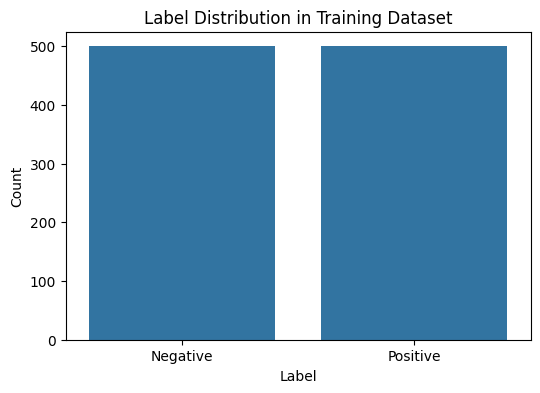

In [ ]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from peft import PeftModel, LoraConfig, get_peft_model
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score


# Load dataset
dataset = load_dataset('shawhin/imdb-truncated')

# Display % of training data with label=1
print(np.array(dataset['train']['label']).sum() / len(dataset['train']['label']))

# Dataset distribution
train_df = pd.DataFrame(dataset['train'])
plt.figure(figsize=(6, 4))
sns.countplot(x=train_df['label'])
plt.title('Label Distribution in Training Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()


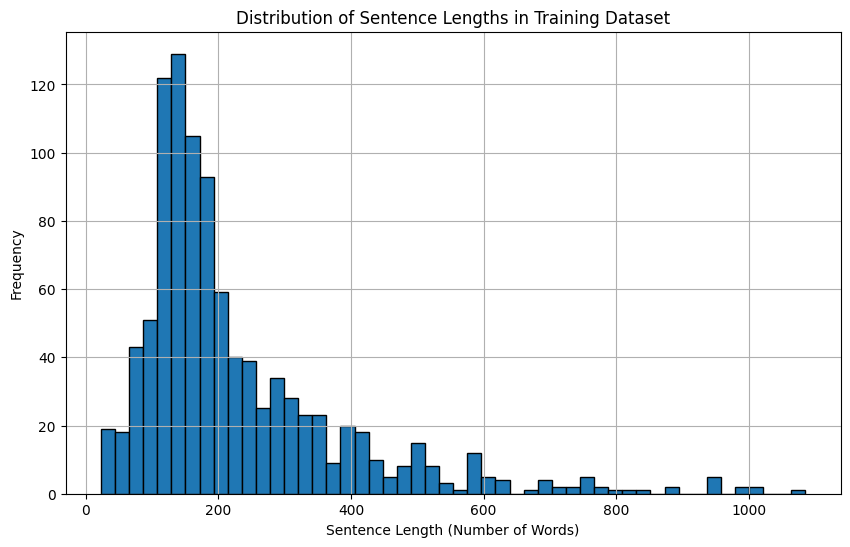

In [ ]:
# Calculate the length of each sentence in the training dataset
train_texts = dataset['train']['text']
sentence_lengths = [len(text.split()) for text in train_texts]

# Plot histogram of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Sentence Lengths in Training Dataset')
plt.xlabel('Sentence Length (Number of Words)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [ ]:

# Specify model checkpoint
model_checkpoint = 'albert/albert-base-v2'

# Define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative": 0, "Positive": 1}

# Generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

# Display architecture
for name, param in model.named_parameters():
    print(name)

# Create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

# Create tokenize function
def tokenize_function(examples):
    text = examples["text"]
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )
    return tokenized_inputs

# Tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    f1 = f1_score(labels, predictions, average='binary')
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "true_positive_rate": tpr,
        "false_positive_rate": fpr
    }


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


albert.embeddings.word_embeddings.weight
albert.embeddings.position_embeddings.weight
albert.embeddings.token_type_embeddings.weight
albert.embeddings.LayerNorm.weight
albert.embeddings.LayerNorm.bias
albert.encoder.embedding_hidden_mapping_in.weight
albert.encoder.embedding_hidden_mapping_in.bias
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.weight
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.bias
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.dense.weight
albert.encoder.al

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:

# Define list of examples
text_list = ["It was good.", "Not a fan, don't recommend.", "Better than the first one.", "Worst movie ever.", "This one is a pass."]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt")
    logits = model(inputs).logits
    predictions = torch.argmax(logits)
    print(text + " - " + id2label[predictions.tolist()])



Untrained model predictions:
----------------------------
It was good. - Positive
Not a fan, don't recommend. - Positive
Better than the first one. - Negative
Worst movie ever. - Positive
This one is a pass. - Positive


In [ ]:
# Inspect the model architecture to identify appropriate target modules
for name, param in model.named_parameters():
    print(name)

# Based on inspection, choose appropriate layers for LoRA
target_modules = ['encoder.albert_layer_groups.0.albert_layers.0.ffn']  # Example target modules, adjust based on inspection

peft_config = LoraConfig(task_type="SEQ_CLS", r=4, lora_alpha=32, lora_dropout=0.01, target_modules=target_modules)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


albert.embeddings.word_embeddings.weight
albert.embeddings.position_embeddings.weight
albert.embeddings.token_type_embeddings.weight
albert.embeddings.LayerNorm.weight
albert.embeddings.LayerNorm.bias
albert.encoder.embedding_hidden_mapping_in.weight
albert.encoder.embedding_hidden_mapping_in.bias
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.weight
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.bias
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.dense.weight
albert.encoder.al

In [ ]:
# Hyperparameters
lr = 1e-3
batch_size = 4
num_epochs = 10

# Define training arguments
training_args = TrainingArguments(
    output_dir=model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


# Train model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positive Rate,False Positive Rate
1,No log,0.583502,0.879000,0.831874,0.950000,0.887021,0.950000,0.192000
2,0.549200,0.674903,0.856000,0.970899,0.734000,0.835991,0.734000,0.022000
3,0.549200,0.418242,0.902000,0.873606,0.940000,0.905588,0.940000,0.136000
4,0.273600,0.408698,0.916000,0.927984,0.902000,0.914807,0.902000,0.070000
5,0.273600,0.394331,0.920000,0.915020,0.926000,0.920477,0.926000,0.086000
6,0.106500,0.410091,0.918000,0.906615,0.932000,0.919132,0.932000,0.096000
7,0.106500,0.532553,0.917000,0.892655,0.948000,0.919496,0.948000,0.114000
8,0.023400,0.604213,0.918000,0.914683,0.922000,0.918327,0.922000,0.086000
9,0.023400,0.654070,0.921000,0.920160,0.922000,0.921079,0.922000,0.080000
10,0.002500,0.679430,0.918000,0.919679,0.916000,0.917836,0.916000,0.080000


TrainOutput(global_step=2500, training_loss=0.19104472975730896, metrics={'train_runtime': 1097.8439, 'train_samples_per_second': 9.109, 'train_steps_per_second': 2.277, 'total_flos': 200883910000224.0, 'train_loss': 0.19104472975730896, 'epoch': 10.0})

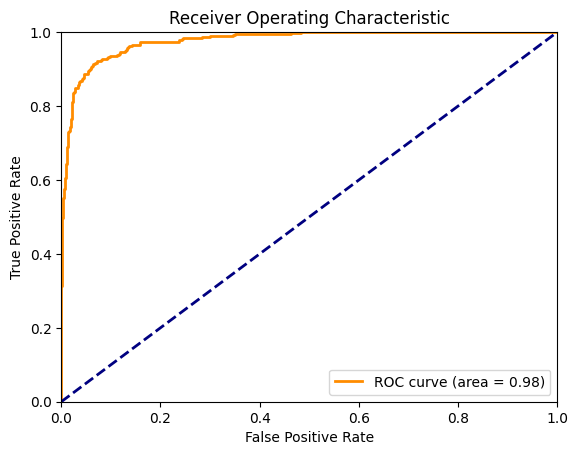

In [ ]:
# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Plot ROC curve
eval_dataset = tokenized_dataset["validation"]
true_labels = np.array(eval_dataset["label"])

trainer.model.eval()
with torch.no_grad():
    predictions = []
    for batch in trainer.get_eval_dataloader():
        # Move batch to the same device as the model
        inputs = {k: v.to(trainer.args.device) for k, v in batch.items() if k != 'labels'}
        logits = trainer.model(**inputs).logits
        predictions.extend(torch.softmax(logits, dim=-1).cpu().numpy()[:, 1])

fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, predictions)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [ ]:
model.to('cpu')

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("cpu")
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    print(text + " - " + id2label[predictions.tolist()[0]])

Trained model predictions:
--------------------------
It was good. - Positive
Not a fan, don't recommend. - Negative
Better than the first one. - Positive
Worst movie ever. - Negative
This one is a pass. - Negative


In [ ]:
# Save the trained model explicitly
model_save_path = training_args.output_dir
trainer.save_model(model_save_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')